The main focus of this notebook is to preprocess a dataset to prepare it for the application of machine learning algorithms and fairness evaluation. The notebook also includes visualizations and statistics to help understand the distribution and correlations of the data.

**PLEASE NOTE**: The notebook must be configured with a dataset and some configuration variables.  
The ***protected attributes*** must be categorical and binary (0,1), but the original column must be mantained as a continuous variable.

##Libraries

In order to run this notebook in Google Colab, you have to:
1. Upload the project folder to your Google Drive
2. Mount your Google Drive in the next code cell
3. Update the `path_to_project` variable, with the path to the project folder in your Google Drive (e.g. `path_to_project = '/content/drive/MyDrive/Colab/project'`), this can be seen from the file tab on the left of the Colab interface
4. Update the pip installation command  (e.g. `!pip install -r /content/drive/MyDrive/Colab/project/requirements.txt`)

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import sys
  path_to_project = '/content/drive/MyDrive/FairAlgorithm'
  sys.path.append(path_to_project)
  !sudo apt install libcairo2-dev pkg-config python3-dev
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
import numpy as np
import pandas as pd
import plotly
np.random.seed(0)
from rich import print
from rich.columns import Columns
from rich.panel import Panel
from rich.align import Align
from source.utils.print_util import *
from source.utils.data_preprocessing import *
import matplotlib.pyplot as plt

## Configuration

In the next code cell, set all the variables that are used throughout the notebook.  
The variables are used to configure the notebook, and to set the paths to the data files.

Modify the variables in the next code cell to configure the notebook
- `dataset_path`: The path to the dataset file.
- `X`: The list of features to use for training and evaluation.
- `Y`: The target feature to predict.
- `Y_labels`: The labels for the target feature.
- `sensible_attribute`: The sensible attribute to use for bias mitigation.
- `G`: The list of sensible attributes to use for bias mitigation.

In [ ]:
dataset_path = path_to_project + '/data/raw/diabetes-women.csv' if IN_COLAB else 'data/raw/diabetes-women.csv'
X = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","AgeCategory"]
Y = 'Outcome'
Y_labels = 'No Diabetes','Diabetes'
sensible_attribute = "AgeCategory"
G = ['AgeCategory']

Name mapping for the sensible attribute

It is possible to decide how to map the sensible attribute values to the labels, as shown in the next code cell, by modifying the `sensible_attribute_map` dictionary.

In [ ]:
sensible_attribute_map = {
    0: "Young",
    1: "Adult",
}

Attribute selection and weighting

The notebook automatically computes the weights based on the 3 selected attributes with the hightest correlation to the target variable. It is possible to choose the attributes manually by setting the `chosen_attributes_manual` variable, otherwise, if it is empy, the notebook will automatically select the attributes with the highest correlation to the target variable.

In [ ]:
chosen_attributes_manual = ['Glucose', 'BMI', 'Age']

## Data load and exploration


Data is loaded from the file specified in the `dataset_path` variable using the `pandas` library.  
[pandas](https://pandas.pydata.org) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool,
built on top of the Python programming language.

In [ ]:
df=pd.read_csv(dataset_path)
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


**Check for missing values**

Missing values in a dataset can introduce bias, reduce accuracy, limit the types of analyses that can be performed, and increase the complexity of analysis. Therefore, it is generally advisable to remove missing values from a dataset, as long as the amount of missing data is not too large. However, the reasons for the missing values should be carefully considered, and in some cases, imputation or specialized methods for handling missing data may be more appropriate.  

`remove_missing_values` function is used to remove rows with missing values.  

In [ ]:
df = remove_missing_values(df)

╭─────────────────────────────────────────── Searching missing values ────────────────────────────────────────────╮
│                                                                                                                 │
╰──────────────────────────────────────────── NO MISSING VALUES FOUND ────────────────────────────────────────────╯

**Check for outliers**

Outliers are data points that deviate significantly from other data points in a dataset, and they can introduce bias, reduce accuracy, lead to misleading results, and increase the complexity of analysis. Outliers are generally considered bad for statistical analysis, and it is important to identify and handle them appropriately to ensure the accuracy and reliability of statistical models and analysis.

First we plot the dataset using a **box plot**, if some attribute has any point outside the box, it means that it has an outlier. For instance, the attribute **Insulin** has multiple outliers. We then use these attributes and **IQR** to remove the outliers.

In [ ]:
fig = plotly.boxplot_frame(df, y=["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"])
fig.show()

In [ ]:
# From the plot, these attributes need further investigation on outliers, so we will use the IQR method to find and remove them
attributes = ["BloodPressure", "SkinThickness", "Insulin", "BMI", "Age"]
df = search_and_remove_outliers(df, attributes)

╭─ Searching outliers for the following attributes: ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age'] ──╮
│                           ┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓                            │
│                           ┃   Attribute   ┃ # Outliers ┃ MAX Outlier ┃ MIN Outlier ┃                            │
│                           ┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩                            │
│                           │ BloodPressure │     45     │     122     │      0      │                            │
│                           │ SkinThickness │     1      │     99      │     99      │                            │
│                           │    Insulin    │     30     │     846     │     326     │                            │
│                           │      BMI      │     8      │    59.4     │     0.0     │                            │
│                           │      Age      │     7      │     81      │     67      │                            │
│                           └───────────────┴────────────┴─────────────┴─────────────┘                            │
╰─────────────────────────────────────────────── OUTLIERS REMOVED ────────────────────────────────────────────────╯

**Feature selection**

Feature selection is a process of identifying the most important and relevant features or variables that contribute the most to a predictive model. It is a crucial step in data preprocessing and analysis, and it helps to improve the accuracy, efficiency, and interpretability of the model.

The correlation matrix is plotted to identify the most correlated attributes. In this case no attribute can be removed since no value is above 0.7.

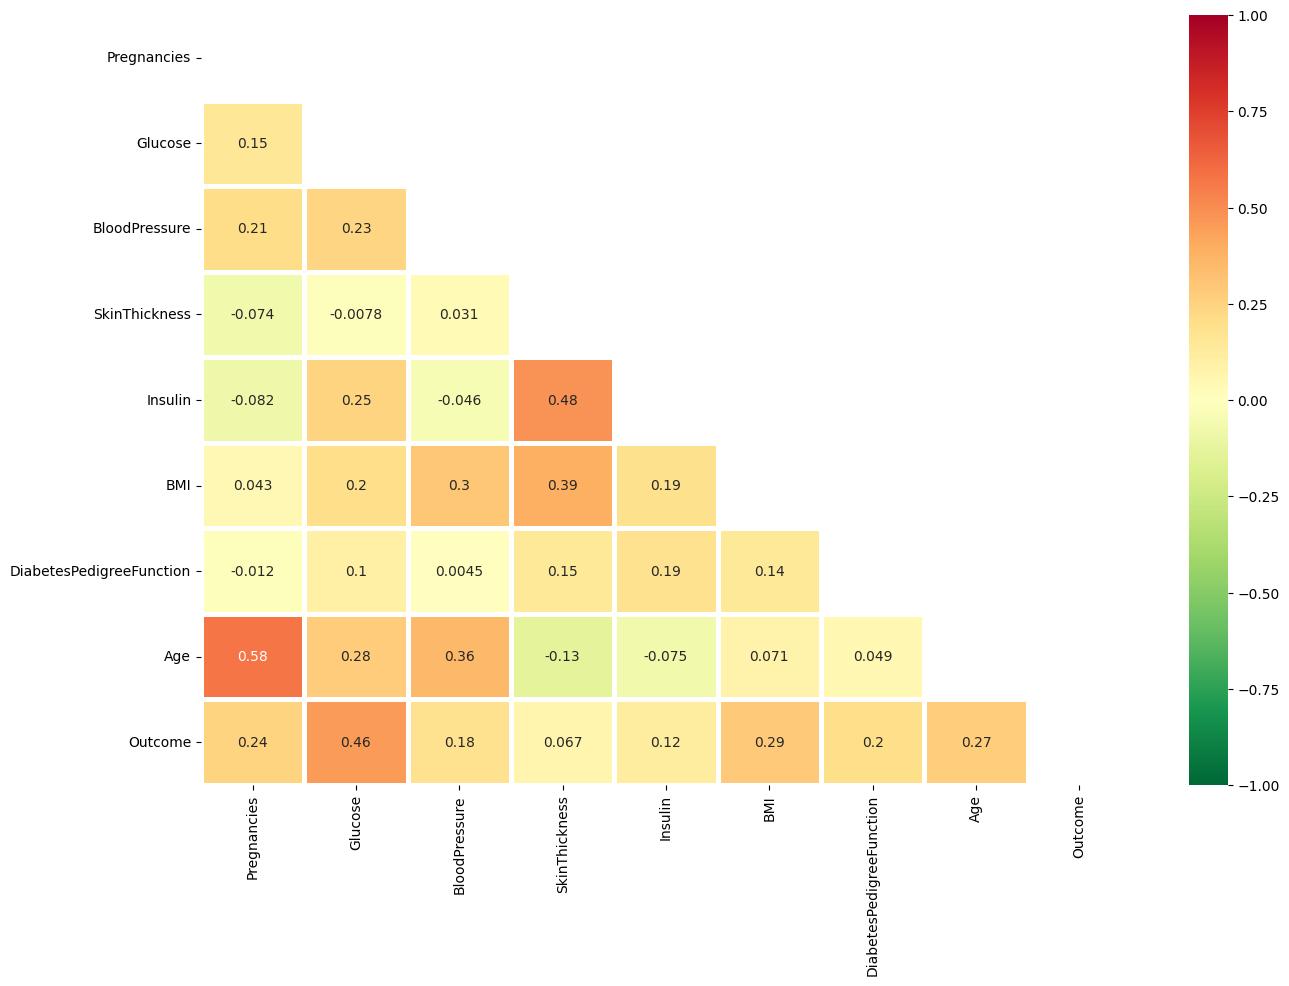

In [ ]:
correlation_matrix = df.corr()
top_corr_features = correlation_matrix.index
print_heatmap(df[top_corr_features].corr())

## Visualisation


A first interesting aspect is to plot the target variable distribution, in order to have a general view of the outcome.  
From the plot we can see the distribution of the target variable.

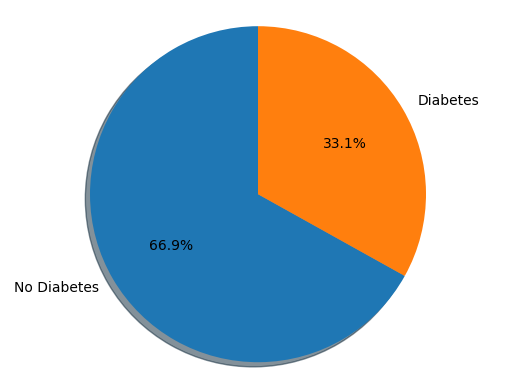

In [ ]:
size0, size1 = df[Y].value_counts()
sizes = [size0, size1]
explode = (0, 0)
fig1, ax1= plt.subplots()
ax1.pie(sizes,explode=explode,labels=Y_labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


Plot Protected Attributes

In [ ]:
df["AgeCategory"] = df.apply(lambda row: age_category(row), axis=1)

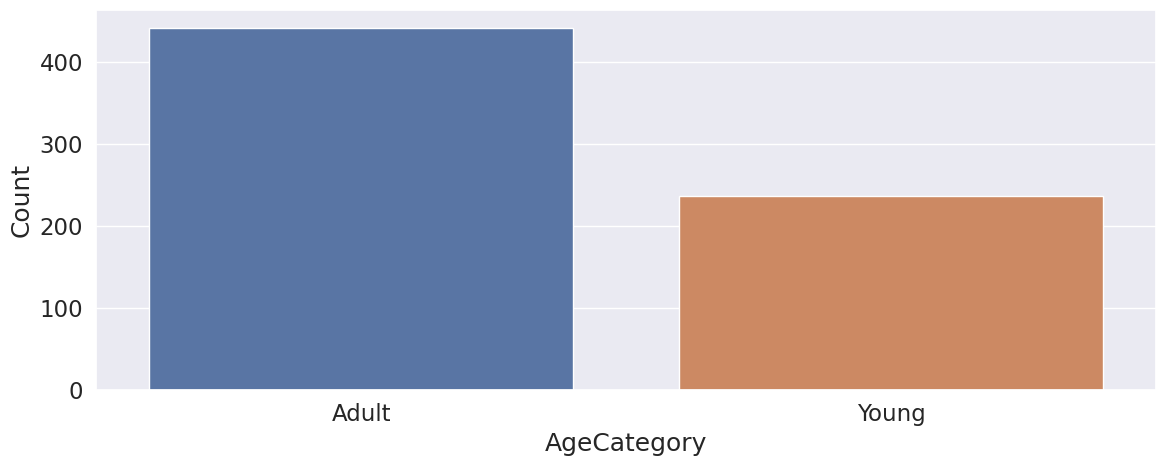

In [ ]:
df_copy = df.copy()
df_copy[sensible_attribute] = df_copy[sensible_attribute].map(sensible_attribute_map)
for attribute in G:
    visualize_att_dist(df_copy, attribute, _category=True)

First of all, the dataset should be normalized and standardized before computing the correlation with the target variable.

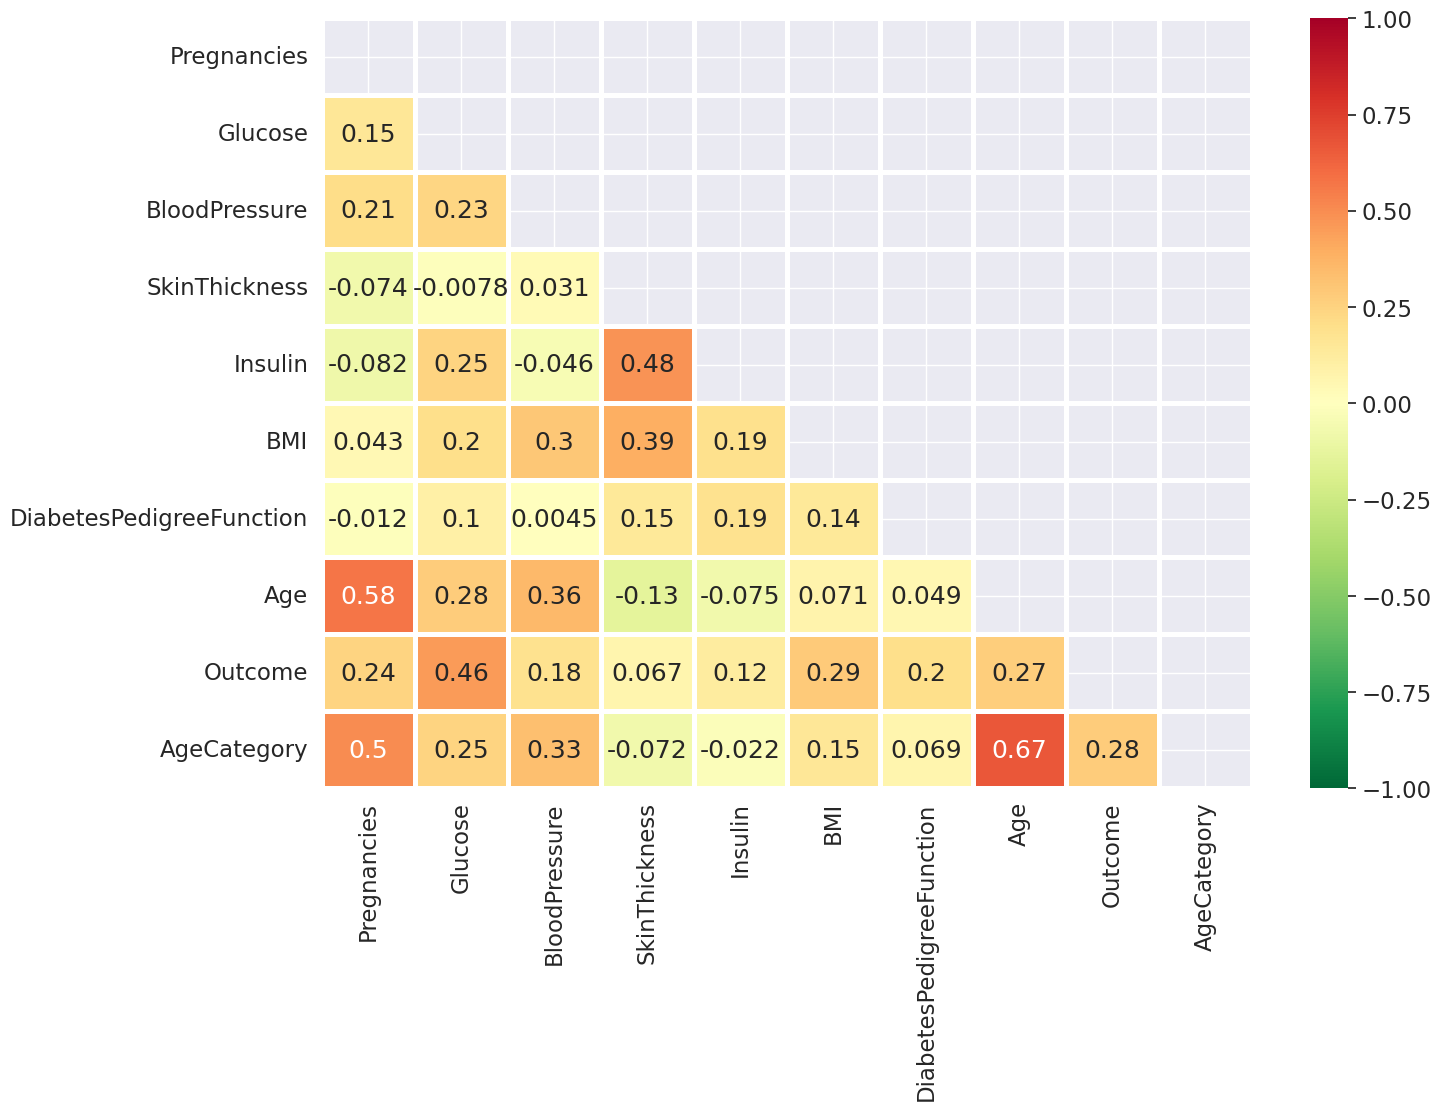

In [ ]:
# Do not consider the protected attribute when you use the Recipe tool
ignore_atts = [Y, sensible_attribute]

cur_data = df.copy()
norm_data = normalizeDataset(cur_data, ignore_atts)
standarded_data = standardizeData(cur_data, ignore_atts)
corr_df = standarded_data.corr(method='pearson')
print_heatmap(corr_df)

## Save preprocessed dataset

In [ ]:
saving_path = path_to_project + '/data/preprocessed/preprocessed-diabetes-women.csv' if IN_COLAB else 'data/preprocessed/preprocessed-diabetes-women.csv'
df.to_csv(saving_path, sep=',', index=False, encoding='utf-8')